# Simulating randomized benchmarking

In this example, we will reproduce a randomized benchmarking experiment used in Figure 3a of [Piltz et. al.](https://www.nature.com/articles/ncomms5679?origin=ppub)

Note: This example is quite computationally expensivem, hence for the full simulation we use [joblib](https://joblib.readthedocs.io/en/latest/) for parallel computing. However, you don't need this to run the demo.


In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import numpy as np
from qutip import sigmax, sigmay, sigmaz, basis, qeye, tensor, Qobj, fock_dm
from qutip_qip.circuit import QubitCircuit, Gate
from qutip_qip.device import ModelProcessor, Model
from qutip_qip.compiler import GateCompiler, Instruction
from qutip import Options
from qutip_qip.noise import Noise

We build a two-qubit Processor, where the second qubit is detuned from the first one by $\delta= 1.852$MHz. A sequence of $\pi$-pulses with Rabi frequency of $\Omega= 20$KHz and random phases are applied to the first qubit. We define noise such that the same pulse also applies to the second qubit. Because of the detuning, this pulse does not flip the second qubit but subjects it to a diffusive behaviour, so that the average fidelity of the second qubit with respect to the initial state decreases.

Here, we reproduce these results with a two-qubit `Processor`.
We start with an initial state of fidelity 0.975 and simulate the Hamiltonian
\begin{align}
H=\Omega(t)(\sigma^x_0 + \lambda \sigma^x_1) + \delta\sigma^z_1
,
\end{align}
where $\lambda$ is the ratio between the cross-talk pulse's amplitudes.

In the cell below, we first build a Hamiltonian model called `MyModel`.
For simplicity, we only include two single-qubit control Hamiltonians: $\sigma_x$ and $\sigma_y$.
We then define the compiling routines for the two types of rotation gates RX and RY.
In addition, we also define a rotation gate with mixed X and Y quadrature, parameterized by a phase $\phi$, $\cos(\phi)\sigma_x+\sin(\phi)\sigma_y$.
This will be used later in the example of custom noise.

We then initialize a `ModelProcessor` with this model.
In the `ModelProcessor`, the default simulation workflow is already defined, such as the `load_circuit` method.
Since rotations around the $x$ and $y$ axes are the native gates of our hardware, we define them in the attribute \texttt{native\_gates}.
Providing this native gates set, rotation around $z$ axis will be automatically decomposed into rotations around $x$ and $y$ axes.
We define a circuit consisting of $\pi/2$ rotation followed by a Z gate.
The compiled pulses are shown in \cref{fig:customize pulse}, where the Z gate is decomposed into rotations around $x$ and $y$ axes.

In [2]:
class MyModel(Model):
    """A custom Hamiltonian model with sigmax and sigmay control."""
    def get_control(self, label):
        """
        Get an available control Hamiltonian.
        For instance, sigmax control on the zeroth qubits is labeled "sx0".

        Args:
            label (str): The label of the Hamiltonian

        Returns:
            The Hamiltonian and target qubits as a tuple (qutip.Qobj, list).
        """
        targets = int(label[2:])
        if label[:2] == "sx":
            return 2 * np.pi * sigmax() / 2, [targets]
        elif label[:2] == "sy":
            return 2 * np.pi * sigmay() / 2, [targets]
        else:
            raise NotImplementError("Unknown control.")

class MyCompiler(GateCompiler):
    """Custom compiler for generating pulses from gates using the base class 
    GateCompiler.

    Args:
        num_qubits (int): The number of qubits in the processor
        params (dict): A dictionary of parameters for gate pulses such as
                       the pulse amplitude.
    """

    def __init__(self, num_qubits, params):
        super().__init__(num_qubits, params=params)
        self.params = params
        self.gate_compiler = {
            "RX": self.single_qubit_gate_compiler,
            "RY": self.single_qubit_gate_compiler,
        }

    def generate_pulse(self, gate, tlist, coeff, phase=0.0):
        """Generates the pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.
            tlist (array): A list of times for the evolution.
            coeff (array): An array of coefficients for the gate pulses
            phase (float): The value of the phase for the gate.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction): An instruction
            to implement a gate containing the control pulses.                                               
        """

        pulse_info = [
            # (control label, coeff)
            ("sx" + str(gate.targets[0]), np.cos(phase) * coeff),
            ("sy" + str(gate.targets[0]), np.sin(phase) * coeff),
        ]
        #print(tlist)
        return [Instruction(gate, tlist=tlist, pulse_info=pulse_info)]

    def single_qubit_gate_compiler(self, gate, args):
        """Compiles single-qubit gates to pulses.
        
        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.
        
        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction): An instruction
            to implement a gate containing the control pulses.
        """
        
        
        # gate.arg_value is the rotation angle
        coeff, tlist= self.generate_pulse_shape(
                "hann",  # Scipy Hann window
                30,  # 100 sampling point
                maximum= 1,
                area= 1,  # 1/2 becuase we use sigmax as the operator instead of sigmax/2
            )
        # tlist = np.abs(gate.arg_value) / self.params["pulse_amplitude"]
        coeff *= self.params["pulse_amplitude"] *gate.arg_value/np.pi
        if gate.name == "RX":
            return self.generate_pulse(gate, tlist, coeff, phase=0.0)
        elif gate.name == "RY":
            return self.generate_pulse(gate, tlist, coeff, phase=np.pi / 2)



# Define a circuit and run the simulation

g_x = Gate("X", 0)
g_y = Gate("Y", 0)


rg_x = Gate("RX", 0, arg_value= np.pi)
rg_y = Gate("RY", 0, arg_value= np.pi)
rg_phx = Gate("RX", 0, arg_value= +np.pi/2)
rg_phy = Gate("RY", 0, arg_value= +np.pi/2)
rg_nhx = Gate("RX", 0, arg_value= -np.pi/2)
rg_nhy = Gate("RY", 0, arg_value= -np.pi/2)


g_z = Gate("Z", 0)
rg_z = Gate("RZ", 0, arg_value= np.pi)

g_nhz = Gate("RZ", 0, arg_value= np.pi/2)

    

total_op = qeye(2)
num_qubits = 1


In [3]:
gates_set = [
    rg_y, g_y
]
circuit = QubitCircuit(1)

single_qubit = basis(2, 0)
for gate in gates_set:
    circuit.add_gate(gate)
    print(gate.name)
    g_qobj = gate.get_compact_qobj()
    print( g_qobj )
    total_op *= g_qobj
print( "Result" )
print( total_op )


RY
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 6.123234e-17 -1.000000e+00]
 [ 1.000000e+00  6.123234e-17]]
Y
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]
Result
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.-1.j 0.+0.j]
 [0.+0.j 0.-1.j]]


{'RX': <bound method MyCompiler.single_qubit_gate_compiler of <__main__.MyCompiler object at 0x0000023E4B1BE4C0>>, 'RY': <bound method MyCompiler.single_qubit_gate_compiler of <__main__.MyCompiler object at 0x0000023E4B1BE4C0>>}
RY Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 6.123234e-17 -1.000000e+00]
 [ 1.000000e+00  6.123234e-17]]
Y Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[-1.  0.]
 [ 0. -1.]]


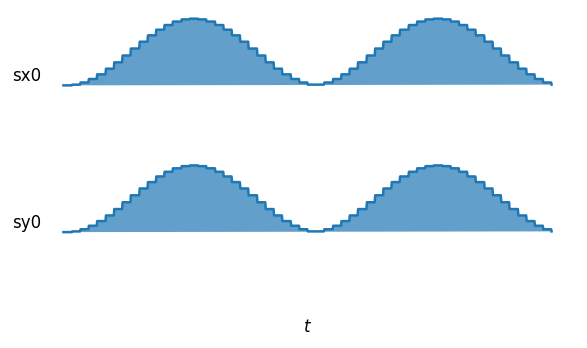

In [4]:
# Simulate the circuit.
myprocessor = ModelProcessor(model=MyModel(num_qubits))
myprocessor.native_gates = ["RX","RY"]
mycompiler = MyCompiler(num_qubits, {"pulse_amplitude": 0.02})
print(mycompiler.gate_compiler)

# raw circuit
for gate in circuit.gates:
    print(gate.name, gate.get_compact_qobj())

# After transpile
total_op = qeye(2)
trans_QC = myprocessor.transpile(circuit)
for gate in trans_QC.gates:
    total_op *= gate.get_compact_qobj()
print(total_op)

tlist, coeffs = myprocessor.load_circuit(circuit, compiler=mycompiler)

# print("tlist",tlist)
# print("coeffs",coeffs)

# plt.plot(tlist["sx0"],coeffs["sx0"])
# plt.show()
# result = myprocessor.run_state(basis(2, 0))

fig, ax = myprocessor.plot_pulses(
    figsize=(5, 3), dpi=120,
    use_control_latex=False
)
ax[-1].set_xlabel("$t$")
fig.tight_layout()

We plot a recorded result as an illustration.

In [5]:
gates_set = [
    rg_x,rg_y,rg_phx,rg_phy,rg_nhx,rg_nhy
]
num_gates = 10

total_op = qeye(2)
for ind in np.random.randint(0, 6, num_gates):
    random_gate = gates_set[ind]
    circuit.add_gate(random_gate)
    print(random_gate.name, random_gate.arg_value/np.pi)

    g_qobj = random_gate.get_compact_qobj()
    print( g_qobj )

    single_qubit = g_qobj*single_qubit
    print( single_qubit )
    total_op *= g_qobj
    #print( total_op )

print(f"total_op")
print(total_op)

    
for ind in range(0, 6):
    compare_gate = gates_set[ind]
    print(compare_gate, compare_gate.arg_value/np.pi)
    g_qobj = compare_gate.get_compact_qobj()
    #print( g_qobj )
    print( total_op == compare_gate )
print( "idle\n", total_op == qeye(2) )

RX 1.0
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[6.123234e-17+0.j 0.000000e+00-1.j]
 [0.000000e+00-1.j 6.123234e-17+0.j]]
Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.+0.j]
 [0.-1.j]]
RX 1.0
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[6.123234e-17+0.j 0.000000e+00-1.j]
 [0.000000e+00-1.j 6.123234e-17+0.j]]
Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-1.]
 [ 0.]]
RX 0.5
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.70710678+0.j         0.        -0.70710678j]
 [0.        -0.70710678j 0.70710678+0.j        ]]
Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.70710678+0.j        ]
 [ 0.        +0.70710678j]]
RX 1.0
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[6.123234e-17+0.j 0.000000e+00-1.j]
 [0.00000

In [6]:
import qutip_qip
print("qutip-qip version:", qutip_qip.version.version)
from qutip.ipynbtools import version_table
version_table()

qutip-qip version: 0.2.2


ModuleNotFoundError: No module named 'Cython'

In [ ]:
gate_set_num = len(gates_set)
circuit = QubitCircuit(1)

# Test all operation
for gate in gates_set:
    name_seq = []
    eff_op = decomposition(gate)
    print(eff_op)